In [1]:
# Imports
import torch
torch.cuda.empty_cache()

import hr_dv2.transform as tr
from hr_dv2.utils import *
from hr_dv2.segment import *
import numpy as np
from PIL import Image

import pydensecrf.densecrf as dcrf

import matplotlib.pyplot as plt


torch.manual_seed(2189)
np.random.seed(2189)


IMG_SIZE = 518
PATCH_SIZE  = 14
PATCH_H, PATCH_W = IMG_SIZE // PATCH_SIZE, IMG_SIZE // PATCH_SIZE
FEAT_DIM = 384

from hr_dv2 import HighResDV2

net = HighResDV2("dinov2_vits14_reg", 4, dtype=torch.float16)
net.cuda()
net.eval()
pass

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [2]:
shift_dists = [i for i in range(1, 3)]
fwd_shift, inv_shift = tr.get_shift_transforms(shift_dists, 'Moore')

fwd, inv = fwd_shift, inv_shift
net.set_transforms(fwd, inv)

In [3]:
transform = tr.get_input_transform(IMG_SIZE, IMG_SIZE)
path = "data/v22.png"
_img = Image.open(path)
h, w = _img.height, _img.width
t = tr.closest_crop(h, w, 14, True)
img_tensor, img = tr.load_image(path, t)
img_arr = np.array(img)


img_tensor.to(torch.float16)
img_tensor = img_tensor.cuda()

In [4]:
print(t)

Compose(
    CenterCrop(size=(364, 490))
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)


In [5]:
h, w, c = img_arr.shape
seg, attn, centers, features = cluster(
    net, img_arr, img_tensor, 80, True, False
)
img_tensor = img_tensor.cpu()

In [6]:
print(img_tensor.shape)

torch.Size([3, 364, 490])


In [7]:

seg = seg.reshape((h, w))
sum_cls = np.sum(attn, axis=0)
density_map, densities = get_attn_density(seg, sum_cls)
densities_arr = np.array(densities)

fg_mask = np.nonzero(densities_arr > np.mean(densities_arr))[0]
bg_mask = np.nonzero(densities_arr < np.mean(densities_arr))[0]

fg_clusters = centers[fg_mask]
bg_clusters = centers[bg_mask]

fg_bg_sims, fg_fg_sims = get_feature_similarities(fg_clusters, bg_clusters)
sim_cutoff = get_similarity_cutoff(fg_bg_sims)
merged_clusters = merge_foreground_clusters(centers, sim_cutoff)

semantic_seg = np.zeros((h, w))
for i, val in enumerate(np.unique(seg)):
    current_class = np.where(seg == val, merged_clusters[i], 0)
    semantic_seg += current_class

unique_merged = np.unique(merged_clusters)
new_centers = np.zeros((len(unique_merged), FEAT_DIM))
for i, val in enumerate(unique_merged):
    current_centers = centers[merged_clusters == val]
    new_centers[i] = np.mean(current_centers, axis=0)

In [35]:
from pydensecrf.utils import unary_from_softmax

new_feats = features[np.newaxis, ...] #np.expand_dims(features, 0) #features.transpose((1, 2, 0))
n_classes = new_centers.shape[0]
print(new_centers.shape)
print(new_feats.shape)
#foo = np.expand_dims( np.expand_dims(new_centers, -1), -1)
foo = new_centers[..., np.newaxis, np.newaxis]
a = np.abs(new_feats - foo)
print(a.shape, foo.shape, new_feats.shape)
distances = np.sum(a, axis=1)

#for i in range(len(new_centers)):
#    delta = np.abs(new_feats - new_centers[i])
#    dist = np.sum(delta, axis=-1)
#    distances[i, :, :] = dist

(3, 384)
(1, 384, 364, 490)
(3, 384, 364, 490) (3, 384, 1, 1) (1, 384, 364, 490)


In [30]:

print(distances.shape)

class CRFParams:
    label_confidence: float = 0.6
    sxy_g: Tuple[int, int] = (3, 3)
    sxy_b: Tuple[int, int] = (80, 80)
    s_rgb: Tuple[int, int, int] = (13, 13, 13)
    compat_g: float = 10
    compat_b: float = 10
    n_infer: int = 10

crf = CRFParams()
distances = distances.astype(np.float32)
unary = np.ascontiguousarray(distances.reshape(n_classes, h*w)) #unary_from_softmax(smax, )
d = dcrf.DenseCRF2D(w, h, n_classes)
u = np.ascontiguousarray(unary)
d.setUnaryEnergy(u)
d.addPairwiseGaussian(
    sxy=crf.sxy_g,
    compat=crf.compat_g,
    kernel=KERNEL,
    normalization=dcrf.NORMALIZE_SYMMETRIC,
)
d.addPairwiseBilateral(
    sxy=crf.sxy_b,
    srgb=crf.s_rgb,
    rgbim=img_arr,
    compat=crf.compat_b,
    kernel=KERNEL,
    normalization=dcrf.NORMALIZE_SYMMETRIC,
)
Q = d.inference(crf.n_infer)
crf_seg = np.argmax(Q, axis=0)
crf_seg = crf_seg.reshape((h, w, 1))

refined = crf_seg.squeeze(-1)

(3, 364, 490)


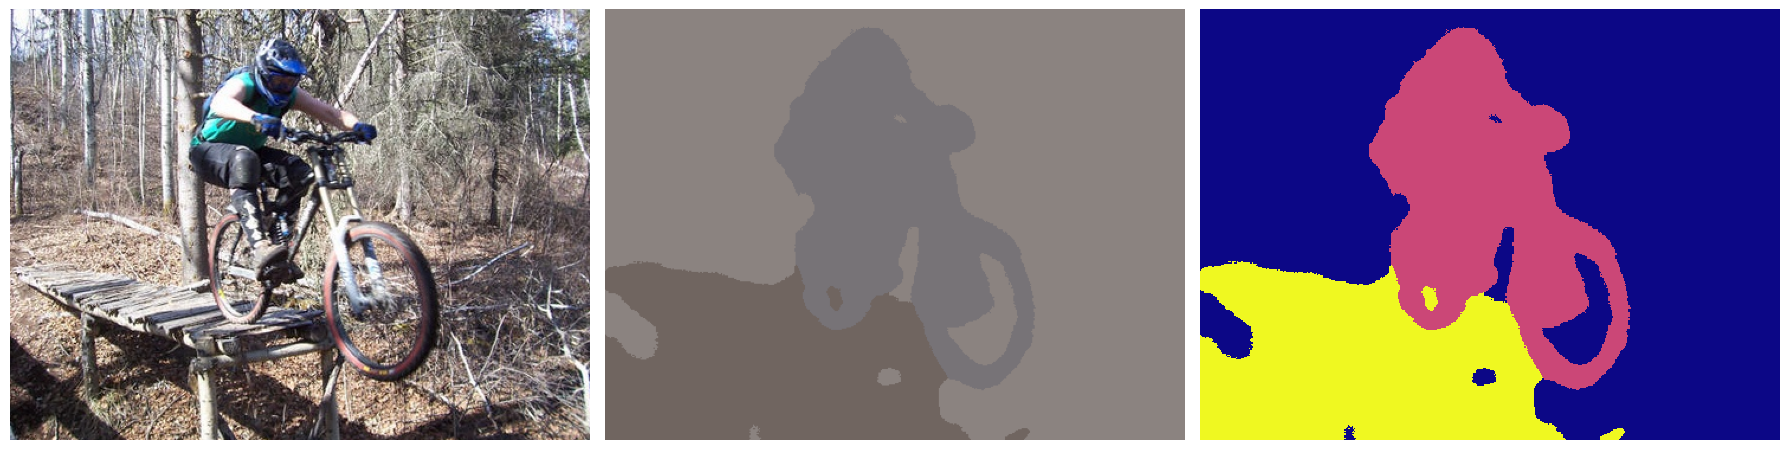

In [31]:
from skimage.color import label2rgb

fig, axs = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(18, 8)
axs[0].imshow(img)
axs[1].imshow(label2rgb(refined, img_arr, kind='avg', bg_label=-1))
axs[2].imshow(refined, cmap="plasma", interpolation="nearest")

for ax in axs:
    ax.set_axis_off()

plt.tight_layout()

In [32]:
refined.shape

(364, 490)

In [33]:
np.unique(refined)
print(np.amax(refined))

2


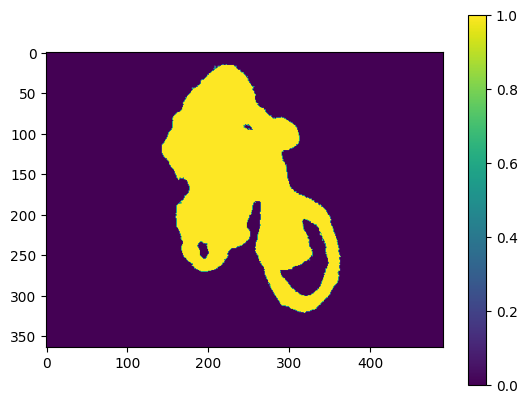

In [34]:
amap, dens = get_attn_density(refined, sum_cls)
plt.imshow(amap > np.mean(dens))
plt.colorbar()